Mini-DEG:
1. turn smiles into graph
2. given graph, randomly sample subgraphs
   a. Each sampled subgraph is contracted and becomes a production rule
   b. Contracted node is designated "non-terminal node"
3. last one is contracted into initial node

Reverse process for generation

Implementing:

![figure](fig.png)

### Data stuff

In [1]:
from rdkit import Chem
import networkx as nx
import random
import itertools

In [2]:
# load samples from samples.txt

with open('samples.txt', 'r') as f:
    samples = f.readlines()

samples

['O=C=C=NCN=C=O\n',
 'CC1=C=NC=NCC(=C=O)C=C1\n',
 'O=C=NC1=CC=CC2(C3=CC=C4C=CCCN=CC=C(C=NCC3)C4)CCCCCC(=C1)CC2\n',
 'Cc1cccc(C)c1\n',
 'Cc1ccc(CC2=CC=C(CC3=CCN=CC=C3)CCN=C2)cc1\n',
 'CC(C)(CCCON=C=O)CCOCN=O\n',
 'O=C=NC(N=C=O)=NC1=CC2=CC=NCCC=C=NC(=C=O)C(=CC=C1)C2\n',
 'O=C=NCCC1CCC(N=C=O)CC1\n',
 'CC(N=C=O)C(C)C(=O)C1CCCCCCCC1\n',
 'CC1=CC=CC(C2=CC=C3C=CCCN=C=CC=C(C=C=NCC2)C3)N=C=C1\n']

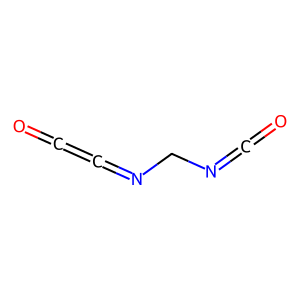

In [3]:
sample = samples[0]
m = Chem.MolFromSmiles(sample)

# display molecule
from rdkit.Chem import Draw
Draw.MolToImage(m)

In [4]:
def mol_to_graph(mol):
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(atom.GetIdx(), element=atom.GetSymbol())
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond_type=bond.GetBondType())
    return g

def graph_to_mol(g):
    mol = Chem.RWMol()
    for node, data in g.nodes(data=True):
        mol.AddAtom(Chem.Atom(data['element']))
    for u, v, data in g.edges(data=True):
        mol.AddBond(u, v, data['bond_type'])
    Chem.SanitizeMol(mol)
    return mol.GetMol()

{(0, 1): Text(-0.8710047927343016, 0.14626228896078108, 'DOUBLE'),
 (1, 2): Text(-0.6166069250936452, 0.04797479656508271, 'DOUBLE'),
 (2, 3): Text(-0.32140418730619236, -0.03569603057673559, 'DOUBLE'),
 (3, 4): Text(-0.006613441181926333, -0.08869882758522585, 'SINGLE'),
 (4, 5): Text(0.3115490069893627, -0.09933515397921647, 'SINGLE'),
 (5, 6): Text(0.6156503250921983, -0.06979526853957019, 'DOUBLE'),
 (6, 7): Text(0.8808599730511311, -0.011231104404829046, 'DOUBLE')}

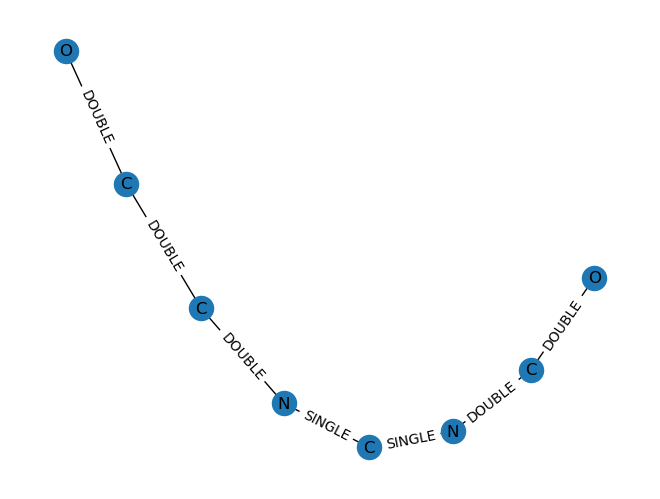

In [5]:
G = mol_to_graph(m)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['bond_type'] for u, v, d in G.edges(data=True)})

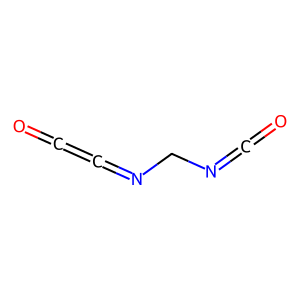

In [6]:
M = graph_to_mol(G)
Draw.MolToImage(M)

### Extract subgraphs

/tmp/ipykernel_2209/3223599961.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))


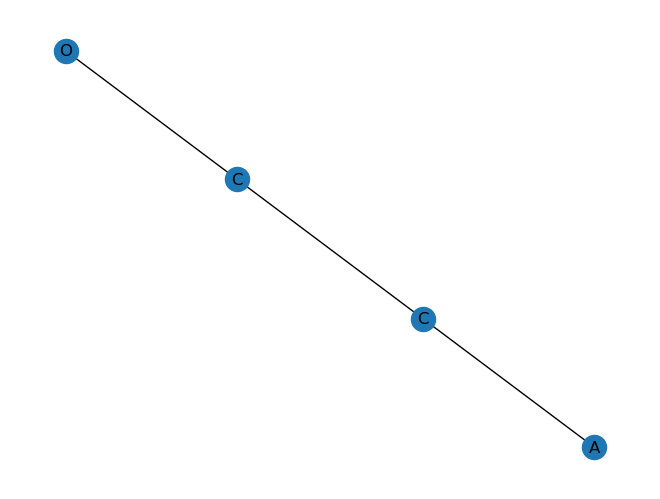

In [7]:
# randomly draw out subgraphs (later on will replace with optimizable edge weights)

def get_subgraph(G):
    while True:
        if G.number_of_nodes() == 1 or G.number_of_nodes() == 2:
            return G
        
        subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))
        if nx.is_connected(subgraph):
            # add anchor nodes to where the subgraph is connected to the rest of the graph, with proper bond types
            for node in subgraph.nodes():
                for neighbor in G.neighbors(node):
                    if neighbor not in subgraph.nodes():
                        subgraph = subgraph.copy()
                        subgraph.add_node(neighbor, element="A")
                        subgraph.add_edge(node, neighbor, bond_type=G[node][neighbor]['bond_type'])

            return subgraph
    
subgraph = get_subgraph(G)
# print(subgraph.nodes(data=True))
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos, labels={n: d['element'] for n, d in subgraph.nodes(data=True)})

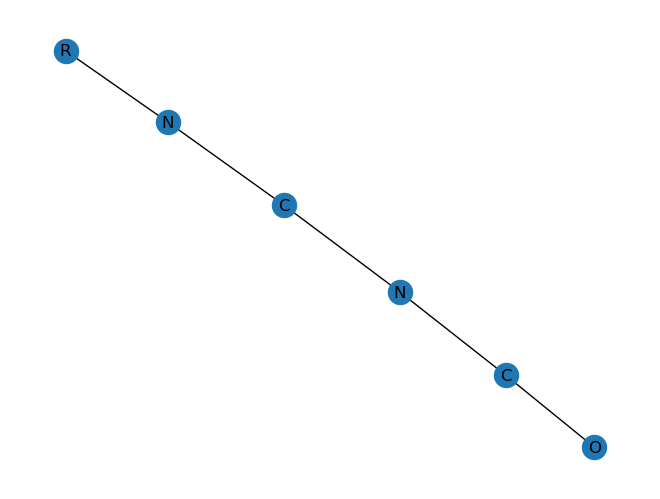

In [8]:
# replace subgraph in graph with non-terminal node

def contract_node(Gc, subgraph):
    
    Gc = G.copy()   
    s_nodes = [n for n in subgraph.nodes() if subgraph.nodes[n]['element'] != 'A']

    # get neighboring edges of subgraph
    neighbors = []
    for node in s_nodes:
        for neighbor in Gc.neighbors(node):
            if neighbor not in s_nodes:
                neighbors.append(neighbor)

    Gc.remove_nodes_from(s_nodes)
    
    # if no nodes left, return empty graph
    if len(Gc.nodes()) == 0:
        return nx.Graph()
    
    # add node in place of subgraph
    idx = max(Gc.nodes()) + 1
    Gc.add_node(idx, element='R')

    # add edges between new node and neighbors of subgraph
    for node in neighbors:
        Gc.add_edge(idx, node, bond_type=Chem.rdchem.BondType.SINGLE)

    return Gc

G = contract_node(G, subgraph)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})

In [9]:
# store production rules in class

class ProductionRule:
    def __init__(self, lhs: nx.Graph, rhs: nx.Graph):
        self.lhs = lhs
        self.rhs = rhs
        
    def __repr__(self):
        # return elements of lhs and rhs
        lhs = [n[1]['element'] for n in self.lhs.nodes(data=True)]
        rhs = [n[1]['element'] for n in self.rhs.nodes(data=True)]
        return f'{lhs} -> {rhs}'

class ProductionRules:
    def __init__(self):
        self.rules = []
        
    def add_rule(self, rule: ProductionRule):
        self.rules.append(rule)
        
    def __repr__(self):
        return f'{self.rules}'
    
    def __len__(self):
        return len(self.rules)

LHS


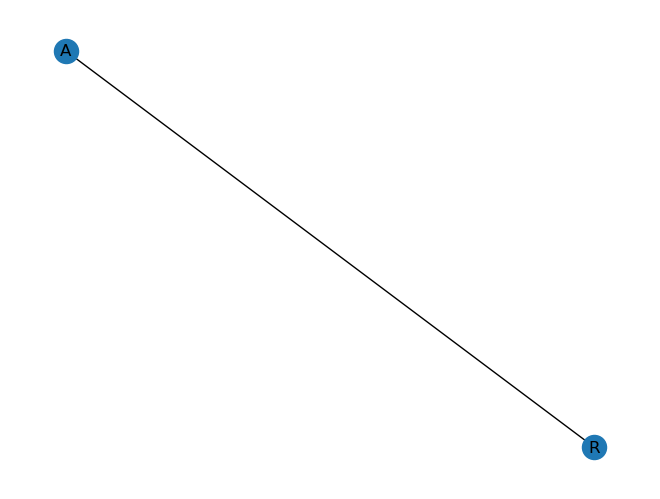

In [10]:
# turn subgraph into production rule

def to_production_rule(G, subgraph):
    """
    lhs is R and adjacent nodes, rhs is R and subgraph
    """
    rhs = subgraph.copy()
    # rhs = nx.relabel_nodes(subgraph, {n: d['element'] for n, d in subgraph.nodes(data=True)})   # relabel nodes with element, not index

    lhs = nx.Graph()
    if G.number_of_nodes() == 0:
        lhs.add_node(0, element='X')    # initial node
    else:
        r_neighbors = [n for n in G.neighbors(max(G.nodes()))]
        lhs.add_node(0, element='R')

        for n in G.neighbors(max(G.nodes())):
            if G.nodes[n]['element'] != 'R':
                # lhs.add_node(max(lhs.nodes())+1, element=G.nodes[n]['element'])
                lhs.add_node(max(lhs.nodes())+1, element='A')   # anchor node
                lhs.add_edge(0, max(lhs.nodes()), bond_type=G.edges[(max(G.nodes()), n)]['bond_type'])
            elif G.nodes[n]['element'] == 'R':
                lhs.add_node(max(lhs.nodes())+1, element='R')
                lhs.add_edge(0, max(lhs.nodes()), bond_type=G.edges[(max(G.nodes()), n)]['bond_type'])

    return ProductionRule(lhs, rhs)

prod = to_production_rule(G, subgraph)

print("LHS")
pos=nx.spring_layout(prod.lhs)
nx.draw(prod.lhs, pos, labels={n: d['element'] for n, d in prod.lhs.nodes(data=True)})

RHS


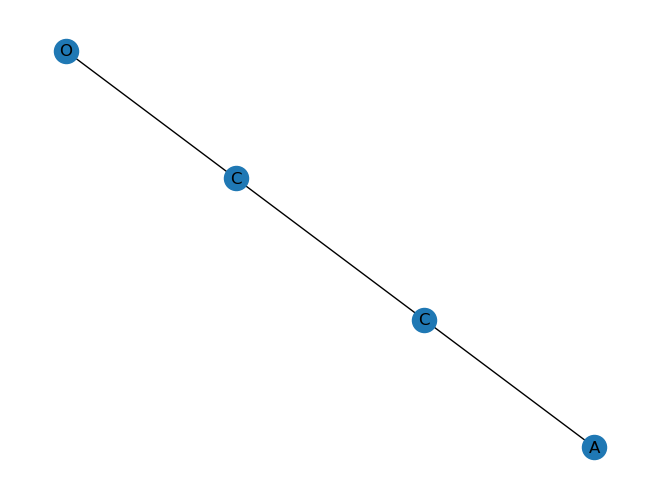

In [11]:
print("RHS")
pos = nx.spring_layout(prod.rhs)
nx.draw(prod.rhs, pos, labels={n: d['element'] for n, d in prod.rhs.nodes(data=True)})

In [12]:
print(prod.lhs.nodes(data=True))
print(prod.rhs.nodes(data=True))

[(0, {'element': 'R'}), (1, {'element': 'A'})]
[(0, {'element': 'O'}), (1, {'element': 'C'}), (2, {'element': 'C'}), (3, {'element': 'A'})]


In [13]:
# add production rule to production rules

rules = ProductionRules()
rules.add_rule(prod)
len(rules)

1

### Full cycle of contracting molecule and getting production rules

{(0, 1): Text(0.8330763171747555, -0.7572604946270551, 'DOUBLE'),
 (1, 2): Text(0.5414166899466638, -0.5695724610590481, 'DOUBLE'),
 (2, 3): Text(0.23000524847336226, -0.3369529476101377, 'DOUBLE'),
 (3, 4): Text(-0.06949832724585586, -0.06520949933762628, 'SINGLE'),
 (4, 5): Text(-0.3361526196122106, 0.23739019073621292, 'SINGLE'),
 (5, 6): Text(-0.5591668700345972, 0.5542639686947097, 'DOUBLE'),
 (6, 7): Text(-0.7269289460359074, 0.8568232515009798, 'DOUBLE')}

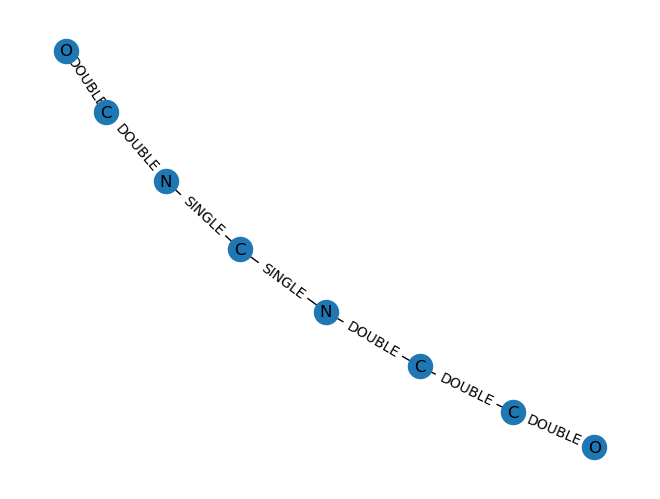

In [14]:
G = mol_to_graph(m)
pos=nx.spring_layout(G)
nx.draw(G, pos, labels={n: d['element'] for n, d in G.nodes(data=True)})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['bond_type'] for u, v, d in G.edges(data=True)})

In [15]:
rules = ProductionRules()

while G.number_of_nodes() > 0:
    subgraph = get_subgraph(G)
    G = contract_node(G, subgraph)
    print(G.nodes(data=True))
    prod = to_production_rule(G, subgraph)
    rules.add_rule(prod)    # TODO: check to make sure rule is not already in rules (prob do this in ProductionRules class)

[(0, {'element': 'O'}), (1, {'element': 'C'}), (2, {'element': 'C'}), (3, {'element': 'N'}), (6, {'element': 'C'}), (7, {'element': 'O'}), (8, {'element': 'R'})]
[(0, {'element': 'O'}), (1, {'element': 'C'}), (2, {'element': 'C'}), (3, {'element': 'R'})]
[(2, {'element': 'C'}), (3, {'element': 'R'}), (4, {'element': 'R'})]
[(3, {'element': 'R'}), (4, {'element': 'R'})]
[]


/tmp/ipykernel_2209/3223599961.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subgraph = G.subgraph(random.sample(G.nodes(), random.randint(2, len(G.nodes())-1)))


In [16]:
rules.rules

[['R', 'A', 'A'] -> ['C', 'N', 'A', 'A'],
 ['R', 'A'] -> ['N', 'C', 'O', 'R', 'A'],
 ['R', 'A'] -> ['O', 'C', 'A'],
 ['R', 'R'] -> ['C', 'R', 'A'],
 ['X'] -> ['R', 'R']]

### (Re)generate  molecule

In [17]:
generated = nx.Graph()
generated.add_node(0, element='X')

generated.nodes(data=True)

NodeDataView({0: {'element': 'X'}})

In [18]:
# check if subgraph matches lhs

def check_match(subgraph, lhs):
    """
    Matches if subgraph has same elements as lhs, where A can be any element
    """
    lhs_elements = ["R" if n[1]['element']=="R" else "A" for n in lhs.nodes(data=True)] # turn all elements into A
    subgraph_elements = [n[1]['element'] for n in subgraph.nodes(data=True)]
    
    if len(lhs_elements) != len(subgraph_elements):
        return False
    
    if lhs_elements != subgraph_elements and lhs_elements != subgraph_elements[::-1]:
        return False
    
    return True

[(2, {'element': 'C'})]
[]


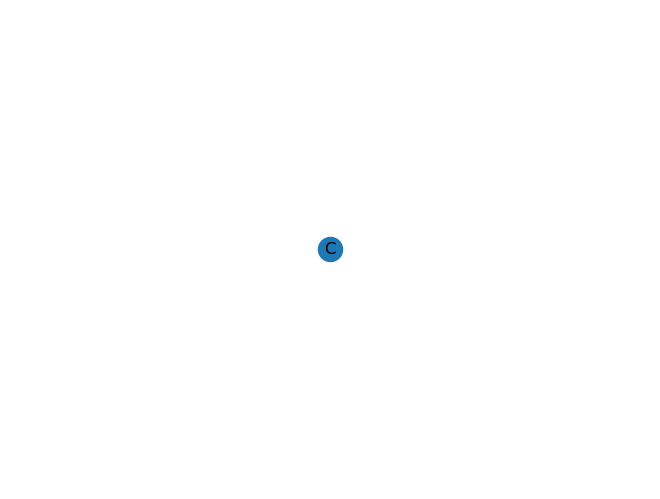

In [19]:
# apply production rule to generate new graph

def apply_rule(G, rule: ProductionRule):

    Gc = G.copy()
    lhs_nodes = list(rule.lhs.nodes())
    rhs_nodes = list(rule.rhs.nodes())
    
    # get all subgraphs with the same number of nodes as lhs
    subgraphs = [Gc.subgraph(s) for s in nx.connected_components(Gc) if len(Gc.subgraph(s).nodes()) == len(lhs_nodes)]
    
    # check if subgraph matches lhs
    for subgraph in subgraphs:
        if check_match(subgraph, rule.lhs): # if subgraph matches lhs, apply rule   
            # add rhs nodes to G
            Gc.add_nodes_from(rhs_nodes)
            for node in rhs_nodes:
                Gc.nodes[node]['element'] = rule.rhs.nodes[node]['element']
            for edge in rule.rhs.edges():
                Gc.add_edge(edge[0], edge[1], bond_type=rule.rhs.edges[edge]['bond_type'])
            
            # get id of anchor node in rhs; if not presnt, then None
            anchor_node = next((n for n in rhs_nodes if rule.rhs.nodes[n]['element'] == 'A'), None)
            # get id of R node in subgraph (which is the same as in Gc), otherwise None
            R_node = [n for n in subgraph.nodes(data=True) if n[1]['element'] == 'R'][0][0]
            
            # add edge from anchor node to R node
            Gc.add_edge(anchor_node, R_node)
            # remove anchor node and R node from Gc
            Gc.remove_node(anchor_node)
            Gc.remove_node(R_node)
    
    return Gc

generated = nx.Graph()
generated.add_node(0, element='X')

# find starting rules

start_rules = [rule for rule in rules.rules if rule.lhs.nodes[0]['element'] == 'X']
start_rule = random.choice(start_rules)
generated = start_rule.rhs.copy()

# apply rules to generate new graph

while any([d['element'] == 'R' for n, d in generated.nodes(data=True)]):    # while there are still R (non-terminal) nodes
    for rule in rules.rules:    # TODO: randomize so not always applying same rule first
        generated = apply_rule(generated, rule)
        
    print(generated.nodes(data=True))
    print(generated.edges(data=True))
    
pos=nx.spring_layout(generated)
nx.draw(generated, pos, labels={n: d['element'] for n, d in generated.nodes(data=True)})

In [20]:
rule.rhs.nodes(data=True)

NodeDataView({3: {'element': 'R'}, 4: {'element': 'R'}})

In [21]:
# check if generated graph is same as original graph

print(nx.is_isomorphic(generated, mol_to_graph(m)))

False


In [22]:
generated.nodes(data=True), generated.edges(data=True)

(NodeDataView({2: {'element': 'C'}}), EdgeDataView([]))

In [23]:
mol_to_graph(m).nodes(data=True), mol_to_graph(m).edges(data=True)

(NodeDataView({0: {'element': 'O'}, 1: {'element': 'C'}, 2: {'element': 'C'}, 3: {'element': 'N'}, 4: {'element': 'C'}, 5: {'element': 'N'}, 6: {'element': 'C'}, 7: {'element': 'O'}}),
 EdgeDataView([(0, 1, {'bond_type': rdkit.Chem.rdchem.BondType.DOUBLE}), (1, 2, {'bond_type': rdkit.Chem.rdchem.BondType.DOUBLE}), (2, 3, {'bond_type': rdkit.Chem.rdchem.BondType.DOUBLE}), (3, 4, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (4, 5, {'bond_type': rdkit.Chem.rdchem.BondType.SINGLE}), (5, 6, {'bond_type': rdkit.Chem.rdchem.BondType.DOUBLE}), (6, 7, {'bond_type': rdkit.Chem.rdchem.BondType.DOUBLE})]))